In [1]:
%load_ext autoreload
%autoreload 2
    
import os
import sys
import time
import glob
import gc

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, random
import optax

%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'Times'

sys.path.insert(0, os.path.abspath(os.path.join('../')))

In [4]:
from geometric_bayesian.utils.types import Size
from flax import nnx

class LogitsModel(nnx.Module):
    def __init__(self, rngs):
        self.layer = nnx.Linear(2, 1, rngs=rngs, use_bias=False)

    def __call__(self, x: jax.Array):
        return self.layer(x).squeeze()

    @property
    def shape(self) -> Size:
        return jnp.array([2, 1])

In [5]:
model = LogitsModel(nnx.Rngs(params=0))

In [6]:
num_samples_1, num_samples_2 = 100, 100
x_1 = jax.random.multivariate_normal(jax.random.key(0), jnp.array([-1,-1]), 0.2*jnp.eye(2), shape=(num_samples_1,))
y_1 = jnp.zeros(num_samples_1)
x_2 = jax.random.multivariate_normal(jax.random.key(0), jnp.array([1,1]), 0.2*jnp.eye(2), shape=(num_samples_2,))
y_2 = jnp.ones(num_samples_2)

In [7]:
from geometric_bayesian.utils import DataLoader
X = jnp.concatenate((x_1,x_2), axis=0)
y = jnp.concatenate((y_1,y_2))

In [8]:
from geometric_bayesian.densities import Bernoulli, MultivariateNormal
from geometric_bayesian.functions.likelihood import neg_logll
from geometric_bayesian.operators.diag_operator import DiagOperator
from geometric_bayesian.utils.helper import pytree_to_array, array_to_pytree

p_ll = lambda f : Bernoulli(f, logits=True)

num_params = sum(p.size for p in jax.tree_util.tree_leaves(nnx.state(model)))
p_prior = MultivariateNormal(jnp.zeros(num_params), DiagOperator(jnp.array(0.1), num_params))

In [9]:
n_epochs = 1000
step_size = 1e-3
optimizer = nnx.Optimizer(model, optax.adam(step_size))

train_loader = DataLoader(X, y, 30, shuffle=True)

@nnx.jit
def train_step(model, optimizer, x, y):
    def loss_fn(model):
        y_pred = model(x)
        return neg_logll(p_ll, y, y_pred) - p_prior._log(pytree_to_array(nnx.state(model)))

    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads) 

    return loss

In [10]:
losses = []
for epoch in range(n_epochs):
    for x_tr, y_tr in train_loader:
        losses.append(train_step(model, optimizer, x_tr, y_tr))

    if epoch % 100 == 0:
        print(f"[epoch {epoch}]: loss: {losses[-1]:.4f}")

print(f'{optimizer.step.value = }')
print(f"Final loss: {losses[-1]:.4f}")

[epoch 0]: loss: 18.9621
[epoch 100]: loss: 11.8418
[epoch 200]: loss: 9.3455
[epoch 300]: loss: 8.7899
[epoch 400]: loss: 8.3313
[epoch 500]: loss: 9.1712
[epoch 600]: loss: 9.1726
[epoch 700]: loss: 8.7068
[epoch 800]: loss: 9.0349
[epoch 900]: loss: 8.3371
optimizer.step.value = Array(7000, dtype=uint32)
Final loss: 9.9959


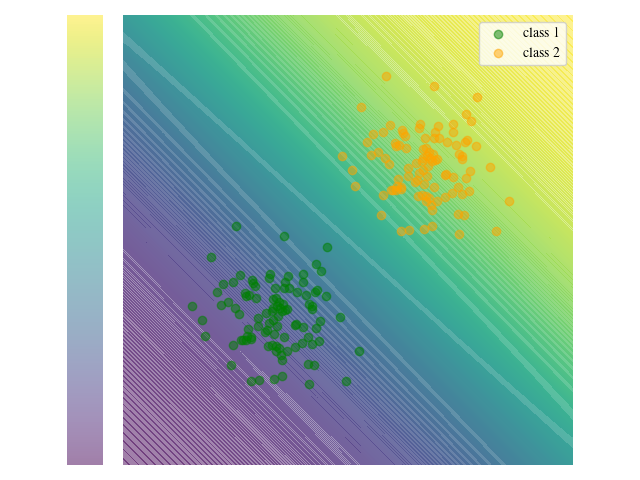

In [11]:
from geometric_bayesian.utils.plot import contour_plot
fig = contour_plot(lambda x: jax.nn.sigmoid(model(x)), min=[-3, -3], max=[3, 3], res=100, iso=False, alpha=0.5, zorder=-1)
ax = fig.axes[0]
ax.scatter(x_1[:,0], x_1[:,1], label='class 1', color='green', alpha=0.5)
ax.scatter(x_2[:,0], x_2[:,1], label='class 2', color='orange', alpha=0.5)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
ax.set_aspect('equal', 'box')
ax.legend()

In [12]:
from geometric_bayesian.utils.helper import wrap_pytree_function
graph_def, map_params = nnx.split(model)
def model_p(params):
    return nnx.call((graph_def, params))(X)[0]
model_p = wrap_pytree_function(model_p, map_params)
num_params = sum(x.size for x in jax.tree.leaves(map_params))
# model_sig = SigmoidModel(nnx.Rngs(params=0))
# nnx.update(model_sig, map_params)

In [13]:
from geometric_bayesian.utils.types import PyTree, Matrix
def loss(params):
    return neg_logll(p_ll, y, model_p(params)) - p_prior._log(params)

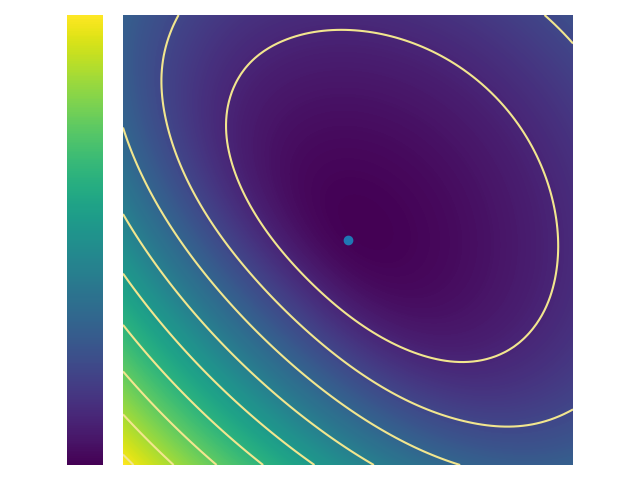

In [14]:
map_p = pytree_to_array(map_params)
p_min, p_max = map_p-10, map_p+10
if len(map_p) == 2:
    fig = contour_plot(jax.vmap(loss), min=p_min, max=p_max, res=100, fig=None)
else:
    res = 100
    x_g, y_g, z_g = jnp.meshgrid(jnp.linspace(p_min[0], p_max[0], res), jnp.linspace(p_min[1], p_max[1], res), jnp.linspace(p_min[2], p_max[2], res))
    eval_fn = jax.vmap(loss)(jnp.vstack((x_g.ravel(), y_g.ravel(), z_g.ravel())).transpose()).reshape(res, res, res)
    x_g, y_g = jnp.meshgrid(jnp.linspace(p_min[1], p_max[1], res), jnp.linspace(p_min[2], p_max[2], res))
    fig = contour_plot((x_g, y_g, jnp.sum(eval_fn, axis=0)), min=p_min, max=p_max, res=100, fig=None)
ax = fig.axes[0]
ax.scatter(*map_p)

In [24]:
from geometric_bayesian.geom.embedding import pullmetric, christoffel_sk
def embedding(x):
    return jnp.array([*x, loss(x)])

csk = christoffel_sk(embedding)

@jax.jit
def dynamics(x,v):
    return -csk(x,v)

In [25]:
jax.lax.map(lambda v : pullmetric(embedding)(map_p, v), jnp.eye(num_params))
# jax.vmap(pullmetric(embedding), in_axes=(None, 0))(map_p, jnp.eye(num_params))

Array([[1352.0276, 1353.0575],
       [1353.0581, 1356.0907]], dtype=float32)

In [26]:
from geometric_bayesian.integrate.integrate import integrate
from geometric_bayesian.integrate.euler_forward import euler_forward

rot = jnp.linspace(0, 2*jnp.pi, 9)[:-1]
x0 = jnp.expand_dims(map_p, axis=0).repeat(rot.shape[0],axis=0)
# x0 = jnp.array([[jnp.pi, jnp.pi]]).repeat(rot.shape[0],axis=0)
v0 = jnp.vstack((jnp.cos(rot),jnp.sin(rot))).transpose()
dt, T = 0.01, 0.4
step = integrate(
    f = dynamics,
    dt = dt,
    T = T,
    integrator = euler_forward,
)

In [27]:
start = time.time()
trajectory_l = jax.vmap(step, in_axes=(0,0))(x0,v0)
print(time.time() - start)

0.3500938415527344


In [28]:
from geometric_bayesian.geom.metric import christoffel_sk
from geometric_bayesian.curv.ggn import ggn
from geometric_bayesian.utils.helper import wrap_pytree_function
ggn_mv = ggn(
    p = p_ll,
    f = model,
    X = X,
    y = y,
)
ggn_mv = wrap_pytree_function(ggn_mv, map_params)
csk = christoffel_sk(ggn_mv)
@jax.jit
def dynamics(x,v):
    return -csk(x,v)

In [29]:
jax.lax.map(lambda v : ggn_mv(map_p, v), jnp.eye(num_params))

Array([[745.24176, 635.28827],
       [635.2882 , 775.58655]], dtype=float32)

In [30]:
from geometric_bayesian.integrate.integrate import integrate
from geometric_bayesian.integrate.euler_forward import euler_forward

rot = jnp.linspace(0, 2*jnp.pi, 9)[:-1]
x0 = jnp.expand_dims(map_p, axis=0).repeat(rot.shape[0],axis=0)
# x0 = jnp.array([[jnp.pi, jnp.pi]]).repeat(rot.shape[0],axis=0)
v0 = jnp.vstack((jnp.cos(rot),jnp.sin(rot))).transpose()
dt, T = 0.01, 0.4
step = integrate(
    f = dynamics,
    dt = dt,
    T = T,
    integrator = euler_forward,
)

In [31]:
start = time.time()
trajectory_g = jax.vmap(step, in_axes=(0,0))(x0,v0)
print(time.time() - start)

0.12851190567016602


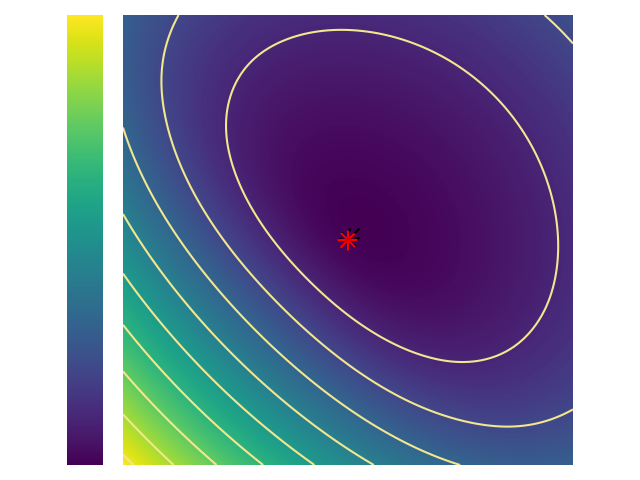

In [32]:
from geometric_bayesian.utils.plot import surf_plot
fig = contour_plot(jax.vmap(loss), min=p_min, max=p_max, res=100)
ax = fig.axes[0]
for i in range(rot.shape[0]):
    traj = trajectory_l[0][i]
    ax.plot(traj[:, 0], traj[:, 1], color="k")
    traj = trajectory_g[0][i]
    ax.plot(traj[:, 0], traj[:, 1], color="r")

In [21]:
def integrate(fn, grid_min, grid_max, res):
    import numpy as np
    dx = jnp.linspace(grid_min[0], grid_max[0], res)
    dy = jnp.linspace(grid_min[1], grid_max[1], res)
    x, y = jnp.meshgrid(dx, dy)
    z = fn(jnp.vstack((x.ravel(), y.ravel())).transpose()).reshape(res, res)
    return np.trapezoid(jnp.trapezoid(z, dy, axis=0), dx, axis=0)

In [22]:
ll = lambda f : jax.vmap(lambda y, f: p_ll(f)(y), in_axes=(0,0))(y,f).sum()
ll_log = lambda f : jax.vmap(lambda y, f: p_ll(f)._log(y), in_axes=(0,0))(y,f).sum()
llXprior = jax.vmap(lambda p: ll(jax.nn.sigmoid(model_p(array_to_pytree(p, map_params))))*p_prior(p))
llXprior_log = jax.vmap(lambda p: ll_log(model_p(array_to_pytree(p, map_params))) + p_prior._log(p))
posterior = lambda p: llXprior_log(p) - jnp.log(integrate(llXprior, p_min, p_max, 100))

In [ ]:
fig = contour_plot(posterior, min=p_min, max=p_max, res=100, fig=None)
ax = fig.axes[0]
ax.scatter(map_p[0], map_p[1])